In [2]:
import setup

In [3]:
import importlib
importlib.reload(setup)

<module 'setup' from '/home/guillermo/Nextcloud/projects/Distributed_Q_gates_clean/Codes/setup.py'>

In [4]:
import numpy as np
import os.path
from numpy import pi, floor, sqrt
from math import pi as π
import scipy.sparse as sp
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import setup

In [5]:
import importlib
importlib.reload(setup)

<module 'setup' from '/home/guillermo/Nextcloud/projects/Distributed_Q_gates_clean/Codes/setup.py'>

In [6]:
styles = ['science']
prefix = '../stylelib/'
sufix = '.mplstyle'
for i in range(len(styles)):
    styles[i] = prefix + styles[i] + sufix
plt.style.use(styles)
plt.rcParams.update({'font.size': 20})

In [ ]:
phase_gate_30m_30MHz = np.load('phase_gate_30m_30MHz.npy')
phase_gate_30m_50MHz = np.load('phase_gate_30m_50MHz.npy')
phase_gate_30m_100MHz = np.load('phase_gate_30m_100MHz.npy')
phase_gate_30m_200MHz = np.load('phase_gate_30m_200MHz.npy')

phase_gate_5m_100MHz = np.load('phase_gate_5m_100MHz.npy')
phase_gate_5m_50MHz = np.load('phase_gate_5m_50MHz.npy')
phase_gate_5m_30MHz = np.load('phase_gate_5m_30MHz.npy')

# Scattering of incoming photon with respect to e/g

We want to numerically study (based on the input-output formulas), the distortion and change in phase of the incoming photon with respect to the reflected ones. We have to do it properly, taking into account the phase effects due to each of the processes. We will begin with a reference photon
$$f(\omega)_{\rm ref_x} = f(\omega) e^{-i \varphi_x} e^{-i 2t \tilde{\omega}(k) } \hspace{.5cm} \text{with} \hspace{.5cm} \varphi_x = \pm \pi/2 + \frac{2}{\kappa} (\omega-\Omega_x) $$
wher $x = e,g$. This represents a photon that travels without distortion and interacts with a cavity for a time $\frac{2}{\kappa}$ acquiring after that interaction a phase $\pm \pi/2$.

The real (simulated) photon however suffers distortion from second order contributions of both non-linear dispersion relation and phase profile upon interaction

$$\tilde{f(\omega)}_x = f(\omega) e^{-i \varphi(\omega)_x} e^{-i 2t \omega(k) } \hspace{.5cm} \text{with} \hspace{.5cm} e^{-i \varphi(\omega)_x} = \frac{\kappa/2+i(\omega-(\Omega \pm \chi))}{-\kappa/2+i(\omega-(\Omega \pm \chi))}$$




([<matplotlib.lines.Line2D at 0x7fd83cc603a0>], 2101)

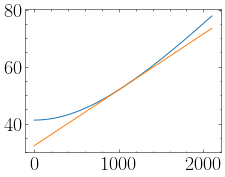

In [8]:
control = setup.Exp2QB2Cavities(ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913, δ2=0, g2=0, κ1=0, κ2 = 2*π*1e-3*100, l=30, mmax=2101)
plt.plot(control.ωrelevant)

np.argmin(np.abs(control.ωrelevant-control.ω1))
control.ωrelevant[1050], control.mcentral , control.mcentral - int(control.mmax/2), int(control.mmax/2)
ω_linear = control.ω1-(control.mcentral*π/30 - control.mrelevant*π/30)*30/control.tprop
plt.plot(ω_linear), ω_linear.size


In [9]:
def sech_photon2(ω, κ):
    γ4 = 1/np.cosh(π*ω/κ)*1/κ**0.5
    γ4 *= np.sqrt(π/2)
    γ4 = γ4/(γ4@γ4)**(0.5)
    γ4 = np.concatenate((np.zeros(4), γ4))
    return γ4

from numpy import pi as π

def Trotter_solver_dynamics(time,v0,control,g1=None,g2=None):
    vt = [v0]
    last_t = time[0]
    for t in time[1:]:
        dt = t - last_t
        v0 = scipy.sparse.linalg.expm_multiply((-1j*dt) * control.Hamiltonian(g1=g1(t), g2=g2(t)), v0)
        vt.append(v0)
        last_t = t
    return np.array(vt).T


In [10]:
def input_output_simulation(η=1, κmax=100, npoints=50, ω=2*π*8.40701933547913, l=30, mmax=1001):
    ϕ_e = [] 
    ϕ_g = []
    z_e = []
    z_g = []
    control = setup.Exp2QB2Cavities(ω1=ω, ω2=ω, l=l, mmax=mmax)
    
#     all_kappas = 2*π*np.linspace(1, κmax, npoints)*1e-3
    all_kappas = 2*π*np.logspace(0, κmax, npoints)*1e-3

    χrange = all_kappas/2
    
    for χ in χrange:
        
        κ = 2*χ
        ω = control.ωrelevant
        Ω = control.ω1
        Ω_e = Ω+κ/2
        Ω_g = Ω-κ/2
        σph = κ/np.sqrt(12)/η
        
        ω_linear = control.ω1-(control.mcentral*π/l - control.mrelevant*π/l)*l/control.tprop
        
        e_ref = sech_photon2(ω-Ω, σph)[4:] * np.exp(-1j*2*control.tprop*(ω_linear)) * np.exp(-1j*((2/κ)*(ω-Ω))) 
        
        g_ref = sech_photon2(ω-Ω, σph)[4:] * np.exp(-1j*2*control.tprop*(ω_linear)) * np.exp(-1j*((2/κ)*(ω-Ω)))
    
        
        e_real = sech_photon2(ω-Ω, σph)[4:] * ((-1j*(ω-(Ω_e))+(0.5*κ))/(-1j*(ω-(Ω_e))-(0.5*κ))) * np.exp(-1j*2*control.tprop*(ω))
        
        g_real =  sech_photon2(ω-Ω, σph)[4:] * ((-1j*(ω-(Ω_g))+(0.5*κ))/(-1j*(ω-(Ω_g))-(0.5*κ))) * np.exp(-1j*2*control.tprop*(ω))
        
#         plt.plot(sech_photon2(ω-Ω, all_kappas[5])[4:])
        
        z_e.append(np.vdot(e_ref,e_real))
        z_g.append(np.vdot(g_ref,g_real))
        
    z_e = np.array(z_e)
    z_g = np.array(z_g)
    return z_e, z_g

In [11]:
def photonic_scattering(σph, ω1=2*π*8.40701933547913, ω2=2*π*8.40701933547913, κ1=0, κ2=0, χ=0, σ=1/2.0,
               extratime=0, Nt=1000, l=30, Nm=2101):

    control1 = setup.Exp2QB2Cavities(ω1=ω1, ω2=ω2, g1=0, g2=0, κ1=κ1, κ2=κ2, l=l, mmax=Nm)

    duration = 2*control1.tprop + extratime 
    time = np.linspace(-duration/2, duration/2, Nt)

    print('New iteration')
    print(f'Cavity width = {κ2/(2*π)}*(2π) GHz')

    # Scattering against positively detuned cavity
    control2 = setup.Exp2QB2Cavities(ω1=ω1, ω2=ω2+χ, g1=0, g2=0, κ1=κ1, κ2=κ2, l=l, mmax=Nm)
    vt2 = Trotter_solver_dynamics(time, sech_photon2(control2.ωrelevant-control2.ω1, σph), control2,
                                  g1 = lambda t: 0, g2 = lambda t: 0)
    ω = control2.ωrelevant
    Ω = control2.ω1
    Ω_e = Ω+κ2/2
    
    ψe = vt2[:,-1]
    ψe_ref = sech_photon2(ω-Ω, σph)[4:] * np.exp(-1j*2*control2.tprop*(ω)) * ((-1j*(ω-(Ω_e))+(0.5*κ2))/(-1j*(ω-(Ω_e))-(0.5*κ2))) # maybe eliminate π/2
    ψe_ref = np.concatenate((np.zeros(4), ψe_ref))
    ψe = np.vdot(ψe_ref.conjugate(), ψe)
    
    # Scattering against positively detuned cavity
    control3 = setup.Exp2QB2Cavities(ω1=ω1, ω2=ω2-χ, g1=0, g2=0, κ1=κ1, κ2=κ2, l=l, mmax=Nm)
    vt3 = Trotter_solver_dynamics(time, sech_photon2(control3.ωrelevant-control3.ω1, σph), control3,
                                  g1 = lambda t: 0, g2 = lambda t: 0)
    
    ω = control3.ωrelevant
    Ω = control3.ω1
    Ω_g = Ω-κ2/2
    ψg = vt3[:,-1]
    ψg_ref = sech_photon2(ω-Ω, σph)[4:] * np.exp(-1j*2*control3.tprop*(ω)) * ((-1j*(ω-(Ω_g))+(0.5*κ2))/(-1j*(ω-(Ω_g))-(0.5*κ2)))
    ψg_ref = np.concatenate((np.zeros(4), ψg_ref))
    ψg = np.vdot(ψg_ref, ψg)

    norm = np.vdot(ψe, ψe)
    overlap = np.vdot(ψe, ψg)

    Pwaveguide = np.sum(np.abs(vt2[4:,-1])**2)
    avgω = np.sum(np.abs(vt2[4:,-1])**2 * control2.ωrelevant) / Pwaveguide
    print(f'|wv(tf)|^2    ={Pwaveguide}\n'
          f'norm          ={norm}\n'
          f'overlap       ={np.abs(overlap)}\n'          
          f'angle e/g     ={np.angle(overlap)/π} * π\n'
          f'angle_e       ={np.angle(ψe)/π} * π\n'
          f'mod_e         ={np.abs(ψe)}\n'
          f'angle_g       ={np.angle(ψg)/π} * π\n'
          f'mod_g        ={np.abs(ψg)}')
    
    return (ψe, ψg, overlap, duration)

In [12]:
all_kappas = 2*π*np.logspace(0, 2, 50)*1e-3
all_kappas[10]

0.016082113900927755

In [13]:
# all_kappas = 2*π*np.linspace(1, 100, 50)*1e-3
all_kappas = 2*π*np.logspace(0, 2, 21)*1e-3

if os.path.exists('photonic_scattering_30m.npy'):
    photonic_scattering_30m = np.load('photonic_scattering_30m.npy')
else:
    photonic_scattering_30m = [photonic_scattering(σph=κ/5/np.sqrt(12) , κ1=κ, κ2=κ, χ=0.5*κ, extratime=2/κ, Nt=500, Nm=1001)
                   for κ in all_kappas]
    photonic_scattering_30m = np.array(photonic_scattering_30m)
    np.save('photonic_scattering_30m_100MHz.npy', photonic_scattering_30m)

New iteration
Cavity width = 0.001*(2π) GHz


<ipython-input-9-008245ba80c8>:2: RuntimeWarning: overflow encountered in cosh
  γ4 = 1/np.cosh(π*ω/κ)*1/κ**0.5


|wv(tf)|^2    =0.4515814252452643
norm          =(0.37542020006971233+0j)
overlap       =0.37467543677726106
angle e/g     =0.3641415978111495 * π
angle_e       =0.16375067493246684 * π
mod_e         =0.6127154315583315
angle_g       =0.5278922727436163 * π
mod_g        =0.6114999190151642
New iteration
Cavity width = 0.0012589254117941673*(2π) GHz
|wv(tf)|^2    =0.43839996515427865
norm          =(0.35537262996757835+0j)
overlap       =0.35466866769174443
angle e/g     =0.37982038511505123 * π
angle_e       =0.9268702587535028 * π
mod_e         =0.596131386497623
angle_g       =-0.6933093561314461 * π
mod_g        =0.5949505020621132
New iteration
Cavity width = 0.0015848931924611139*(2π) GHz
|wv(tf)|^2    =0.432796656812545
norm          =(0.3017686716040586+0j)
overlap       =0.30126652372209395
angle e/g     =0.3856708336908957 * π
angle_e       =-0.7027935509325592 * π
mod_e         =0.5493347536830877
angle_g       =-0.31712271724166347 * π
mod_g        =0.5484206518925164
New it

In [14]:
psie_e = np.array(photonic_scattering_30m[:,0])
psie_g = np.array(photonic_scattering_30m[:,1])
oute_outg = np.array(photonic_scattering_30m[:,2])

<ipython-input-9-008245ba80c8>:2: RuntimeWarning: overflow encountered in cosh
  γ4 = 1/np.cosh(π*ω/κ)*1/κ**0.5


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


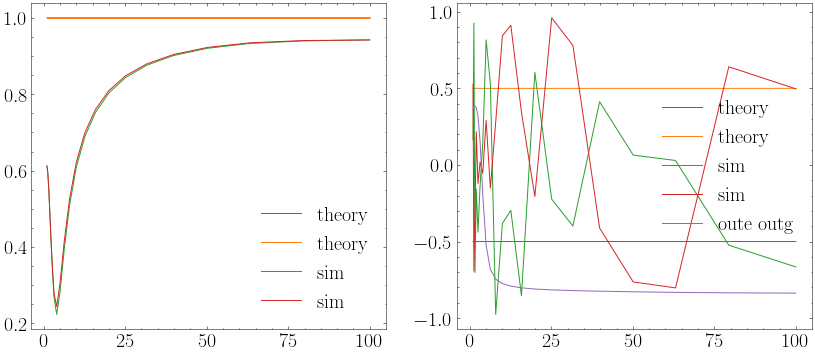

In [15]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(14,6))

ze, zg = input_output_simulation(η=5, κmax=2, npoints=21, ω=2*π*8.40701933547913, l=30)

ax1.plot(all_kappas*1e3/2/π, np.abs(ze), label='theory')
ax2.plot(all_kappas*1e3/2/π, np.angle(ze)/π,label='theory')

ax1.plot(all_kappas*1e3/2/π, np.abs(zg), label='theory')
ax2.plot(all_kappas*1e3/2/π, np.angle(zg)/π, label='theory')

ax1.plot(all_kappas*1e3/2/π, np.abs(psie_e),label='sim')
ax2.plot(all_kappas*1e3/2/π, np.angle(psie_e)/π,label='sim')

ax1.plot(all_kappas*1e3/2/π, np.abs(psie_g),label='sim')
ax2.plot(all_kappas*1e3/2/π, np.angle(psie_g)/π,label='sim')

ax2.plot(all_kappas*1e3/2/π, np.angle(oute_outg)/π,label='oute outg')


ax1.legend()
ax2.legend()

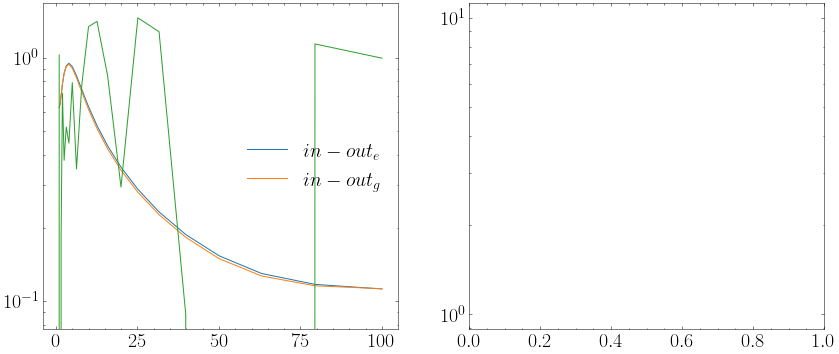

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))


ax1.plot(all_kappas*1e3/2/π,1-np.abs(psie_e)**2, label='$in-out_e$')
ax1.plot(all_kappas*1e3/2/π,1-np.abs(psie_g)**2, label='$in-out_g$')

# ax1.set_xlabel('$\\eta$')
# ax1.set_ylabel('$1-|Z|$')
ax1.legend()
ax1.plot(all_kappas*1e3/2/π, 0.5 + np.angle(psie_g)/π)
# ax2.set_xlabel('$\\eta$')
# ax2.set_ylabel('$1-\\varphi/\\pi$')
# ax2.legend()
ax1.set_yscale('log')
ax2.set_yscale('log')

plt.show()

In [17]:
all_kappas = 2*π*np.linspace(1, 100, 21)*1e-3
all_kappas = 2*π*np.logspace(0, 2, 21)*1e-3


if os.path.exists('photonic_scattering_5m.npy'):
    photonic_scattering_5m = np.load('photonic_scattering_5m.npy')
else:
    photonic_scattering_5m = [photonic_scattering(σph=all_kappas[0]/np.sqrt(12)/4, ω1=2*π*8.416408398466828, ω2=2*π*8.416408398466828, κ1=0, κ2=κ, χ=0.5*κ, extratime=0, l=5,  Nm=351)
                        for κ in all_kappas]
    
    photonic_scattering_5m = np.array(photonic_scattering_5m, dtype=object)

SyntaxError: unexpected character after line continuation character (<ipython-input-17-1003c8df6c26>, line 8)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(14,6))

ze, zg = input_output_simulation(κ=2*π*1e-3*100, κmax=2*π*1e-3*100, npoints=21, ω=2*π*8.40701933547913, l=30)

ax.plot(all_kappas*1e3/2/π, np.abs(ze))
ax.plot(all_kappas*1e3/2/π, np.angle(ze)/π)

ax.plot(all_kappas*1e3/2/π, np.abs(zg))
ax.plot(all_kappas*1e3/2/π, np.angle(zg)/π)

ax.plot(all_kappas*1e3/2/π, np.abs(psie_e))
ax.plot(all_kappas*1e3/2/π, np.angle(psie_e)/π)
ax.plot(all_kappas*1e3/2/π, np.abs(psie_g))
ax.plot(all_kappas*1e3/2/π, np.angle(psie_g)/π)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
moduluse, modulusg, ϕmaxe, ϕmaxg =input_output_estimation_improved()

ax1.plot(np.linspace(1,10,42),1-moduluse**2, label='$in-out_e$')
ax1.plot(np.linspace(1,10,42),1-modulusg**2, label='$in-out_g$')
ax1.plot(np.linspace(1,10,42),1-(moduluse*modulusg), label='$1-\\psi_e\\psi_g$')

ax1.plot(np.linspace(1,10,42),1-np.abs(np.array(phase_gate_30m_100MHz)[:,2]),label =r'Simulated 30m 100MHz')


ax1.set_xlabel('$\\eta$')
ax1.set_ylabel('$1-|Z|$')
ax1.legend()
ax2.plot(np.linspace(1,10,42),1-np.angle(np.array(phase_gate_30m_100MHz)[:,2])/π,label =r'Simulated 30m 100MHz')

ax2.set_xlabel('$\\eta$')
ax2.set_ylabel('$1-\\varphi/\\pi$')
ax2.legend()
ax1.set_yscale('log')
ax2.set_yscale('log')

plt.show()

# Plot for the article In-out_e

## Value of the e/g asymetry

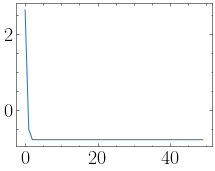

In [387]:
plt.plot(np.angle(input_output_simulation(κmax=100)[1]))